In [1]:
import cobra
from cobra.medium import minimal_medium
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

import numpy as np
import pandas as pd

In [2]:
'''load the base model for REL606.'''
base_model = cobra.io.read_sbml_model('../metabolic-modeling/iECB_1328.xml.gz')
max_growth = base_model.slim_optimize()
base_model.medium = minimal_medium(base_model, max_growth)

''' set glucose to 1.0. This is to set relative molarity of citrate and glucose in the media properly,
so that growth yields of Cit- on DM25 and Cit+ on DM0 and DM25 are "apples to apples". '''
citminus_medium = base_model.medium
citminus_medium['EX_glc__D_e'] = 1.0
base_model.medium = citminus_medium

In [3]:
''' add this reaction to maeA: nad[c] + oaa[c] ->pyr[c] + nadh[c].
    This reaction is the difference between base_model and maeA_model.'''

maeA_side_reaction = cobra.Reaction('MAEA')
maeA_side_reaction.name = 'maeA_side_rxn '
maeA_side_reaction.subsystem = 'Anaplerotic Reactions'
maeA_side_reaction.lower_bound = 0.  # This is the default
maeA_side_reaction.upper_bound = 1000.  # This is the default

maeA_model = base_model.copy()
maeA_model.add_reaction(maeA_side_reaction)

''' 
cite: 
https://www.uniprot.org/uniprot/C3TAB2
https://en.wikipedia.org/wiki/Malate_dehydrogenase_(oxaloacetate-decarboxylating)
https://enzyme.expasy.org/EC/1.1.1.38
'''

maeA_side_reaction.add_metabolites({
    'oaa_c': -1.0,
    'pyr_c': 1.0,
    'co2_e': 1.0,
})

maeA_side_reaction.reaction

'oaa_c --> co2_e + pyr_c'

In [4]:
''' TODO: USE CITROBACTER AS A CONTROL
    PROBLEM: KBase and BiGG database IDs are not compatible!
    Have to figure out how to do the mapping.. so skip this for now. 
    load the curated Citrobacter model (Cuepas et al. 2016)
    use this model as a positive control to compare flux distribution.'''
citrobacter_model = cobra.io.read_sbml_model('../metabolic-modeling/C.sedlakii_MAP_gapfill.sbml')
citro_max_growth = citrobacter_model.slim_optimize()
''' give citrobacter the same media as base'''
base_model.medium
#citrobacter_model.medium = minimal_medium(base_model, max_growth)

{'EX_ca2_e': 0.005113800273256523,
 'EX_cl_e': 0.005113800273256523,
 'EX_cobalt2_e': 2.4561960966649965e-05,
 'EX_cu2_e': 0.000696577213014193,
 'EX_fe2_e': 0.015779586200559713,
 'EX_glc__D_e': 1.0,
 'EX_k_e': 0.19177291387853226,
 'EX_mg2_e': 0.008523000455427539,
 'EX_mn2_e': 0.0006788926011182051,
 'EX_mobd_e': 0.00012673971858791382,
 'EX_nh4_e': 10.611576699826303,
 'EX_ni2_e': 0.0003173405356891175,
 'EX_o2_e': 17.57432917781992,
 'EX_pi_e': 0.9477291587688313,
 'EX_so4_e': 0.24779088701595114,
 'EX_zn2_e': 0.0003350251475851055}

In [5]:
''' NOTE: This code uses BiGG model IDs (BiGG namespace).'''
def generate_models(basemodel):
    ''' Cit- model growing on glucose (no citrate flux)'''
    glucose_model = basemodel.copy()
    ''' Cit+ model on DM0 with citrate flux'''
    DM0citrate_model = basemodel.copy()
    ## set glucose to zero, and citrate to 10.0.
    DM0 = DM0citrate_model.medium
    DM0['EX_glc__D_e'] = 0.0
    DM0['EX_cit_e'] = 10.0
    DM0citrate_model.medium = DM0

    assert 'EX_cit_e' in DM0citrate_model.medium
    assert 'EX_glc__D_e' not in DM0citrate_model.medium
    assert 'EX_glc__D_e' in glucose_model.medium
    assert 'EX_cit_e' not in glucose_model.medium

    ''' Cit+ model on DM25 with citrate flux'''
    DM25citrate_model = DM0citrate_model.copy()
    DM25 = DM25citrate_model.medium
    DM25['EX_glc__D_e'] = 1.0
    DM25['EX_cit_e'] = 10.0
    DM25citrate_model.medium = DM25

    ''' now make the fermentation (no O2 influx) models.'''
    glucose_fermentation_model = glucose_model.copy()
    noO2_media = glucose_fermentation_model.medium
    noO2_media['EX_o2_e'] = 0.0
    glucose_fermentation_model.medium = noO2_media
    
    DM0citrate_fermentation_model = DM0citrate_model.copy()
    DM0_noO2_media = DM0citrate_fermentation_model.medium
    DM0_noO2_media['EX_o2_e'] = 0.0
    DM0citrate_fermentation_model.medium = DM0_noO2_media
    
    DM25citrate_fermentation_model = DM25citrate_model.copy()
    DM25_noO2_media = DM25citrate_fermentation_model.medium
    DM25_noO2_media['EX_o2_e'] = 0.0
    DM25citrate_fermentation_model.medium = DM25_noO2_media
    
    
    return (glucose_model, DM0citrate_model, DM25citrate_model,glucose_fermentation_model, DM0citrate_fermentation_model, DM25citrate_fermentation_model)

In [6]:
old_cit_minus_model, old_DM0_cit_plus_model, old_DM25_cit_plus_model,old_cit_minus_ferment_model, old_DM0_cit_plus_ferment_model, old_DM25_cit_plus_ferment_model = generate_models(base_model)

new_cit_minus_model, new_DM0_cit_plus_model, new_DM25_cit_plus_model,new_cit_minus_ferment_model, new_DM0_cit_plus_ferment_model, new_DM25_cit_plus_ferment_model = generate_models(maeA_model)

In [7]:
old_cit_minus_solution = old_cit_minus_model.optimize()
old_DM0_cit_plus_solution = old_DM0_cit_plus_model.optimize()
old_DM25_cit_plus_solution = old_DM25_cit_plus_model.optimize()

new_cit_minus_solution = new_cit_minus_model.optimize()
new_DM0_cit_plus_solution = new_DM0_cit_plus_model.optimize()
new_DM25_cit_plus_solution = new_DM25_cit_plus_model.optimize()

In [8]:
old_cit_minus_ferment_solution = old_cit_minus_ferment_model.optimize()
old_DM0_cit_plus_ferment_solution = old_DM0_cit_plus_ferment_model.optimize()
old_DM25_cit_plus_ferment_solution = old_DM25_cit_plus_ferment_model.optimize()

new_cit_minus_ferment_solution = new_cit_minus_ferment_model.optimize()
new_DM0_cit_plus_ferment_solution = new_DM0_cit_plus_ferment_model.optimize()
new_DM25_cit_plus_ferment_solution = new_DM25_cit_plus_ferment_model.optimize()

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


In [9]:
''' all fermentation solutions are dead.'''
print(new_cit_minus_ferment_solution.objective_value)
print(new_DM0_cit_plus_ferment_solution.objective_value)
print(new_DM25_cit_plus_ferment_solution.objective_value)

0.0
0.0
7.550017039170328e-30


In [10]:
print(new_cit_minus_solution.objective_value)
print(new_DM0_cit_plus_solution.objective_value)
print(new_DM25_cit_plus_solution.objective_value)

0.08648808133366338
0.5774694918498211
0.6877045311129086


In [11]:
''' no predicted flux through Citrate Lyase.'''
print(new_cit_minus_solution['CITL'])
print(new_DM25_cit_plus_solution['CITL'])
print(new_DM0_cit_plus_solution['CITL'])

0.0
0.0
0.0


In [12]:
''' This is the canonical rxn catalyzed by MaeA'''
print(old_cit_minus_solution['ME1'])
print(old_DM25_cit_plus_solution['ME1'])
print(old_DM0_cit_plus_solution['ME1'])

0.0
0.0
0.0


In [13]:
print(old_cit_minus_solution['ME2'])
print(old_DM25_cit_plus_solution['ME2'])
print(old_DM0_cit_plus_solution['ME2'])

0.0
6.791459892307894
6.187856834140581


In [14]:
''' This is the canonical rxn catalyzed by MaeA'''
print(new_cit_minus_solution['ME1'])
print(new_DM25_cit_plus_solution['ME1'])
print(new_DM0_cit_plus_solution['ME1'])

0.0
0.0
0.0


In [15]:
print(old_cit_minus_solution['ME2'])
print(old_DM25_cit_plus_solution['ME2'])
print(old_DM0_cit_plus_solution['ME2'])

0.0
6.791459892307894
6.187856834140581


In [16]:
print(new_cit_minus_solution['MAEA'])
print(new_DM25_cit_plus_solution['MAEA'])
print(new_DM0_cit_plus_solution['MAEA'])

0.0
16.223185320804287
19.600451438519187


In [17]:
''' look at pyruvate in the old models'''
print(old_cit_minus_model.metabolites.pyr_c.summary())
print('************************')
print(old_DM25_cit_plus_model.metabolites.pyr_c.summary())
print('************************')
print(old_DM0_cit_plus_model.metabolites.pyr_c.summary())

PRODUCING REACTIONS -- Pyruvate (pyr_c)
---------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
80%  1       GLCptspp  glc__D_p + pep_c --> g6p_c + pyr_c
19%  0.244   PYK       adp_c + h_c + pep_c --> atp_c + pyr_c
1%   0.0133  CYSTL     cyst__L_c + h2o_c --> hcys__L_c + nh4_c + pyr_c

CONSUMING REACTIONS -- Pyruvate (pyr_c)
---------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
79%  0.989   PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
12%  0.151   ACLS      h_c + 2.0 pyr_c --> alac__S_c + co2_c
4%   0.0503  ALATA_L   akg_c + ala__L_c <=> glu__L_c + pyr_c
3%   0.0321  DHDPS     aspsa_c + pyr_c --> 23dhdp_c + 2.0 h2o_c + h_c
2%   0.0251  ACHBS     2obut_c + h_c + pyr_c --> 2ahbut_c + co2_c
None
************************
PRODUCING REACTIONS -- Pyruvate (pyr_c)
-----------------------------------

In [18]:
''' look at pyruvate in the models'''
print(new_cit_minus_model.metabolites.pyr_c.summary())
print('************************')
print(new_DM25_cit_plus_model.metabolites.pyr_c.summary())
print('************************')
print(new_DM0_cit_plus_model.metabolites.pyr_c.summary())

PRODUCING REACTIONS -- Pyruvate (pyr_c)
---------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
80%  1       GLCptspp  glc__D_p + pep_c --> g6p_c + pyr_c
19%  0.244   PYK       adp_c + h_c + pep_c --> atp_c + pyr_c
1%   0.0133  CYSTL     cyst__L_c + h2o_c --> hcys__L_c + nh4_c + pyr_c

CONSUMING REACTIONS -- Pyruvate (pyr_c)
---------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
79%  0.989   PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
12%  0.151   ACLS      h_c + 2.0 pyr_c --> alac__S_c + co2_c
4%   0.0503  ALATA_L   akg_c + ala__L_c <=> glu__L_c + pyr_c
3%   0.0321  DHDPS     aspsa_c + pyr_c --> 23dhdp_c + 2.0 h2o_c + h_c
2%   0.0251  ACHBS     2obut_c + h_c + pyr_c --> 2ahbut_c + co2_c
None
************************
PRODUCING REACTIONS -- Pyruvate (pyr_c)
-----------------------------------

In [19]:
''' let us look for reactions which increase flux in response to higher glucose input,
    but decrease flux in response to higher citrate input, or vice-versa.
    These would be candidate reactions for antagonistic pleiotropy.'''

## increment glucose or citrate influx from 10.0 to 11.0.
## note that result is somewhat sensitive to +/- epsilon: MAEA is pleiotropic for -e but not +e.
epsilon = 0.01

glucose_model_dx = new_cit_minus_model.copy()
citrate_model_dy = new_DM0_cit_plus_model.copy()
DM25_dx = new_cit_minus_model.medium
DM0_dy = new_DM0_cit_plus_model.medium
DM25_dx['EX_glc__D_e'] = DM25_dx['EX_glc__D_e'] - epsilon
DM0_dy['EX_cit_e'] = DM0_dy['EX_cit_e'] - epsilon
glucose_model_dx.medium = DM25_dx
citrate_model_dy.medium = DM0_dy
glucose_dx_solution = glucose_model_dx.optimize()
citrate_dy_solution = citrate_model_dy.optimize()

citrate_solution = new_DM0_cit_plus_model.optimize()
glucose_solution = new_cit_minus_model.optimize()

dCdy = citrate_dy_solution.fluxes - citrate_solution.fluxes
dGdx = glucose_dx_solution.fluxes - glucose_solution.fluxes

flux_derivative = pd.DataFrame({'dCdy':dCdy,'dGdx':dGdx})
flux_derivative['vec_norm'] = np.sqrt(np.square(flux_derivative).sum(axis=1))
flux_derivative['product'] = flux_derivative['dCdy']*flux_derivative['dGdx']

In [20]:
flux_derivative2 = flux_derivative[flux_derivative['vec_norm'] > epsilon]

In [21]:
''' this result shows no tradeoff between glucose and citrate, neglecting the costs of gene expression.
    what if I fix oxaloacetate decarboxylation at some value? Perhaps some tradeoff. But gene regulation could
    alleviate the tradeoff.'''

''' my initial thinking/result was that maeA flux is sensitive to changes in glucose and citrate.
    But this finding does not seem to hold up-- this idea is cool so I keep the code, but "result"
    will not be presented.'''

dGdx_norm = np.sqrt(np.square(flux_derivative['dGdx']).sum())
dCdy_norm = np.sqrt(np.square(flux_derivative['dCdy']).sum())
theta = np.arccos(flux_derivative2['dCdy'].dot(flux_derivative2['dGdx'])/(dGdx_norm*dCdy_norm))
print(theta)
flux_derivative2.sort_values('vec_norm').round(2)

1.5273503961756658


,dCdy,dGdx,vec_norm,product
EX_glc__D_e,0.00,0.01,0.01,0.00
GLCtex_copy1,0.00,-0.01,0.01,-0.00
GLCptspp,0.00,-0.01,0.01,-0.00
ICL,-0.01,0.00,0.01,-0.00
MALS,-0.01,-0.00,0.01,0.00
PDH,-0.01,-0.01,0.01,0.00
EX_nh4_e,0.01,0.01,0.01,0.00
NH4tpp,-0.01,-0.01,0.01,0.00
NH4tex,-0.01,-0.01,0.01,0.00
FUM,-0.01,-0.00,0.01,0.00


In [22]:
''' look at acetyl-CoA in the old models'''
print(old_cit_minus_model.metabolites.accoa_c.summary())
print('************************')
print(old_DM25_cit_plus_model.metabolites.accoa_c.summary())
print('************************')
print(old_DM0_cit_plus_model.metabolites.accoa_c.summary())

PRODUCING REACTIONS -- Acetyl-CoA (accoa_c)
-------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
95%  0.989   PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
5%   0.0504  ACS       ac_c + atp_c + coa_c --> accoa_c + amp_c + ppi_c

CONSUMING REACTIONS -- Acetyl-CoA (accoa_c)
-------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
69%  0.715   CS        accoa_c + h2o_c + oaa_c --> cit_c + coa_c + h_c
6%   0.0616  ACACT1r   2.0 accoa_c <=> aacoa_c + coa_c
4%   0.039   IPPS      3mob_c + accoa_c + h2o_c --> 3c3hmp_c + coa_c +...
3%   0.0308  ACACT3r   accoa_c + hxcoa_c <=> 3oocoa_c + coa_c
3%   0.0308  ACACT4r   accoa_c + occoa_c <=> 3odcoa_c + coa_c
3%   0.0308  ACACT5r   accoa_c + dcacoa_c <=> 3oddcoa_c + coa_c
3%   0.0308  ACACT2r   accoa_c + btcoa_c <=> 3ohcoa_c + coa_c
2%   0.0256  AC

In [23]:
''' look at acetyl-CoA in the models'''
print(new_cit_minus_model.metabolites.accoa_c.summary())
print('************************')
print(new_DM25_cit_plus_model.metabolites.accoa_c.summary())
print('************************')
print(new_DM0_cit_plus_model.metabolites.accoa_c.summary())

PRODUCING REACTIONS -- Acetyl-CoA (accoa_c)
-------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
95%  0.989   PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
5%   0.0504  ACS       ac_c + atp_c + coa_c --> accoa_c + amp_c + ppi_c

CONSUMING REACTIONS -- Acetyl-CoA (accoa_c)
-------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
69%  0.715   CS        accoa_c + h2o_c + oaa_c --> cit_c + coa_c + h_c
6%   0.0616  ACACT1r   2.0 accoa_c <=> aacoa_c + coa_c
4%   0.039   IPPS      3mob_c + accoa_c + h2o_c --> 3c3hmp_c + coa_c +...
3%   0.0308  ACACT3r   accoa_c + hxcoa_c <=> 3oocoa_c + coa_c
3%   0.0308  ACACT4r   accoa_c + occoa_c <=> 3odcoa_c + coa_c
3%   0.0308  ACACT5r   accoa_c + dcacoa_c <=> 3oddcoa_c + coa_c
3%   0.0308  ACACT2r   accoa_c + btcoa_c <=> 3ohcoa_c + coa_c
2%   0.0256  AC

## Are there any thermodynamically infeasible loops in this FBA solution? Do Loopless FBA (using the CycleFreeFlux algorithm) to see where MaeA flux goes.
### See documentation at: https://cobrapy.readthedocs.io/en/latest/loopless.html


In [24]:
%matplotlib inline
import cobra.test
from cobra import Reaction, Metabolite, Model
from cobra.flux_analysis.loopless import add_loopless, loopless_solution

In [27]:
loopless_new_cit_minus_solution = loopless_solution(new_cit_minus_model)
loopless_new_DM0_cit_plus_solution = loopless_solution(new_DM0_cit_plus_model)
loopless_new_DM25_cit_plus_solution = loopless_solution(new_DM25_cit_plus_model)

In [28]:
cit_minus_comp_df = pd.DataFrame(dict(loopless=loopless_new_cit_minus_solution.fluxes, nominal=new_cit_minus_solution.fluxes))
DM0_cit_plus_comp_df = pd.DataFrame(dict(loopless=loopless_new_DM0_cit_plus_solution.fluxes, nominal=new_DM0_cit_plus_solution.fluxes))
DM25_cit_plus_comp_df = pd.DataFrame(dict(loopless=loopless_new_DM25_cit_plus_solution.fluxes, nominal=new_DM25_cit_plus_solution.fluxes))

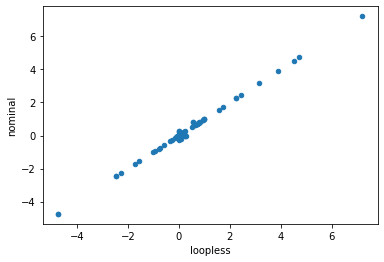

In [32]:
cit_minus_comp_df.plot.scatter(x='loopless', y='nominal')

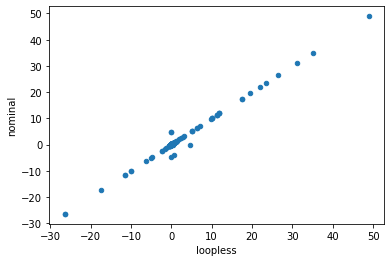

In [33]:
DM0_cit_plus_comp_df.plot.scatter(x='loopless', y='nominal')

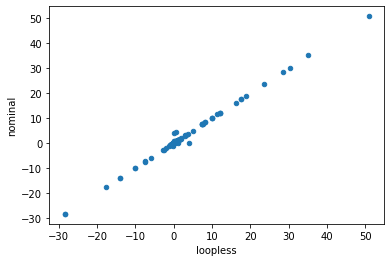

In [34]:
DM25_cit_plus_comp_df.plot.scatter(x='loopless', y='nominal')

In [36]:
print(loopless_new_cit_minus_solution.objective_value)
print(loopless_new_DM0_cit_plus_solution.objective_value)
print(loopless_new_DM25_cit_plus_solution.objective_value)
print(new_cit_minus_solution.objective_value)
print(new_DM0_cit_plus_solution.objective_value)
print(new_DM25_cit_plus_solution.objective_value)

0.0
0.0
0.0
0.08648808133366338
0.5774694918498211
0.6877045311129086


In [37]:
print(loopless_new_cit_minus_solution['MAEA'])
print(loopless_new_DM25_cit_plus_solution['MAEA'])
print(loopless_new_DM0_cit_plus_solution['MAEA'])

-2.3080956289023192e-14
16.223185320804426
19.600451438519194


In [38]:
''' look at pyruvate in the models, after loopless solution.'''
print(new_cit_minus_model.metabolites.pyr_c.summary())
print('************************')
print(new_DM25_cit_plus_model.metabolites.pyr_c.summary())
print('************************')
print(new_DM0_cit_plus_model.metabolites.pyr_c.summary())

PRODUCING REACTIONS -- Pyruvate (pyr_c)
---------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
77%  1       GLCptspp    glc__D_p + pep_c --> g6p_c + pyr_c
19%  0.244   PYK         adp_c + h_c + pep_c --> atp_c + pyr_c
3%   0.0366  VPAMTr_...  3mob_c + ala__L_c <=> pyr_c + val__L_c
1%   0.0133  CYSTL       cyst__L_c + h2o_c --> hcys__L_c + nh4_c + pyr_c

CONSUMING REACTIONS -- Pyruvate (pyr_c)
---------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
76%  0.989   PDH         coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
12%  0.151   ACLS        h_c + 2.0 pyr_c --> alac__S_c + co2_c
7%   0.0869  ALATA_L     akg_c + ala__L_c <=> glu__L_c + pyr_c
2%   0.0321  DHDPS       aspsa_c + pyr_c --> 23dhdp_c + 2.0 h2o_c + h_c
2%   0.0251  ACHBS       2obut_c + h_c + pyr_c --> 2ahbut_c + co2_c
None
************

In [39]:
''' look at acetyl-CoA in the models, after loopless solution'''
print(new_cit_minus_model.metabolites.accoa_c.summary())
print('************************')
print(new_DM25_cit_plus_model.metabolites.accoa_c.summary())
print('************************')
print(new_DM0_cit_plus_model.metabolites.accoa_c.summary())

PRODUCING REACTIONS -- Acetyl-CoA (accoa_c)
-------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
95%  0.989   PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
5%   0.0504  ACS       ac_c + atp_c + coa_c --> accoa_c + amp_c + ppi_c

CONSUMING REACTIONS -- Acetyl-CoA (accoa_c)
-------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
69%  0.715   CS        accoa_c + h2o_c + oaa_c --> cit_c + coa_c + h_c
6%   0.0616  ACACT1r   2.0 accoa_c <=> aacoa_c + coa_c
4%   0.039   IPPS      3mob_c + accoa_c + h2o_c --> 3c3hmp_c + coa_c +...
3%   0.0308  ACACT2r   accoa_c + btcoa_c <=> 3ohcoa_c + coa_c
3%   0.0308  ACACT3r   accoa_c + hxcoa_c <=> 3oocoa_c + coa_c
3%   0.0308  ACACT4r   accoa_c + occoa_c <=> 3odcoa_c + coa_c
3%   0.0308  ACACT5r   accoa_c + dcacoa_c <=> 3oddcoa_c + coa_c
2%   0.0256  AC

In [40]:
''' look at citrate in the models, after loopless solution'''
print(new_cit_minus_model.metabolites.cit_c.summary())
print('************************')
print(new_DM25_cit_plus_model.metabolites.cit_c.summary())
print('************************')
print(new_DM0_cit_plus_model.metabolites.cit_c.summary())

PRODUCING REACTIONS -- Citrate (cit_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  -----------------------------------------------
100%   0.715  CS        accoa_c + h2o_c + oaa_c --> cit_c + coa_c + h_c

CONSUMING REACTIONS -- Citrate (cit_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  -----------------------------------------------
100%   0.715  ACONTa    cit_c <=> acon_C_c + h2o_c
None
************************
PRODUCING REACTIONS -- Citrate (cit_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  -----------------------------------------------
83%    10     CITt7pp   cit_p + succ_c --> cit_c + succ_p
17%     1.99  CS        accoa_c + h2o_c + oaa_c --> cit_c + coa_c + h_c

CONSUMING REACTIONS -- Citrate (cit_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  -------------------------------

In [41]:
''' look at malate in the models, after loopless solution'''
print(new_cit_minus_model.metabolites.mal__L_c.summary())
print('************************')
print(new_DM25_cit_plus_model.metabolites.mal__L_c.summary())
print('************************')
print(new_DM0_cit_plus_model.metabolites.mal__L_c.summary())

PRODUCING REACTIONS -- L-Malate (mal__L_c)
------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  -----------------------------------------
100%   0.712  FUM       fum_c + h2o_c <=> mal__L_c

CONSUMING REACTIONS -- L-Malate (mal__L_c)
------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  -----------------------------------------
73%    0.523  MDH       mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
27%    0.189  DMALRED   fad_c + mal__L_c --> fadh2_c + oaa_c
None
************************
PRODUCING REACTIONS -- L-Malate (mal__L_c)
------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
59%   12     FUM       fum_c + h2o_c <=> mal__L_c
41%    8.26  MALS      accoa_c + glx_c + h2o_c --> coa_c + h_c + mal__L_c

CONSUMING REACTIONS -- L-Malate (mal__L_c)
------------------------------------------
%      FLUX  RXN I

In [42]:
''' look at oxaloacetate in the models, after loopless solution'''
print(new_cit_minus_model.metabolites.oaa_c.summary())
print('************************')
print(new_DM25_cit_plus_model.metabolites.oaa_c.summary())
print('************************')
print(new_DM0_cit_plus_model.metabolites.oaa_c.summary())

PRODUCING REACTIONS -- Oxaloacetate (oaa_c)
-------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  -----------------------------------------------
54%   0.523  MDH       mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
26%   0.256  PPC       co2_c + h2o_c + pep_c --> h_c + oaa_c + pi_c
20%   0.189  DMALRED   fad_c + mal__L_c --> fadh2_c + oaa_c

CONSUMING REACTIONS -- Oxaloacetate (oaa_c)
-------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  -----------------------------------------------
74%   0.715  CS        accoa_c + h2o_c + oaa_c --> cit_c + coa_c + h_c
26%   0.253  ASPTA     akg_c + asp__L_c <=> glu__L_c + oaa_c
None
************************
PRODUCING REACTIONS -- Oxaloacetate (oaa_c)
-------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  -----------------------------------------------
93%   18.7   MDH       mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
7%    

In [43]:
''' look at NADH in the models, after loopless solution'''
print(new_cit_minus_model.metabolites.nadh_c.summary())
print('************************')
print(new_DM25_cit_plus_model.metabolites.nadh_c.summary())
print('************************')
print(new_DM0_cit_plus_model.metabolites.nadh_c.summary())


PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide - reduced (nadh_c)
---------------------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
43%   1.72   GAPD      g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
24%   0.989  PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
15%   0.622  AKGDH     akg_c + coa_c + nad_c --> co2_c + nadh_c + succ...
13%   0.523  MDH       mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
4%    0.149  PGCD      3pg_c + nad_c --> 3php_c + h_c + nadh_c
1%    0.039  IPMD      3c2hmp_c + nad_c --> 3c4mop_c + h_c + nadh_c

CONSUMING REACTIONS -- Nicotinamide adenine dinucleotide - reduced (nadh_c)
---------------------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
96%   3.88   NADH16pp  4.0 h_c + nadh_c + q8_c --> 3.0 h_p + nad_c +